# SP Procurement Data Investigation

11/11/2024

We look at the bidding data for 01/2020 available from GDrive. For each auction, we have a tender code that identifies the auction, the municipality that it is in, the entity that is conducting the auction, the object of the auction, some columns related to the requested item, and the bidder. So there are multiple entries for each auction: one entry for each item + bidder combination. Further, there are more duplicates. It appears that some of the auctions are "cross-listed" across multiple municipalities. This results in duplicate entries for the same auction (including for every item and bidder). In these cases there is one set of entries in one municipality and one big buyer from that municipality (say the whole govt) and a duplicate set of entries in another municipality, also with the whole municipality govt. For simplicity of analysis, I subset to the municipality with the largest number of auctions, Sao Paulo.

Statistics about the overall data:
- Number of auctions: 7,715
- Number of entities (buyers): 1,225
- Number of bidders: 11,343
- Number of categories of objects: 25
- Number of municipalities: 518 (the two biggest: Sao Paulo and Pirangi, some with just one auction)

After subsetting to Sao Paulo:
- Number of auctions: 2063
- Number of entities (buyers): 167
- Number of bidders: 3699

Each auction can have multiple items and multiple bidders. Bidders do not necessarily have to bid for all items, they can bid for just some.
- The auctions have up to almost 200 items, though this is right-tailed, the mean is around 4.
- Each auction has around 7 bidders on average, and each item has around 4 bidders on average, both of these distribution as expected are also right tailed.
- Auctions end with a winner around 63% of the time.

For some auctions, the same item appears to be listed multiple times with either different budgets or different quantities. It isn't clear if this is the same item relisted or if this is multiple different repeat items, each with different quantities and budgets. 

If we assume that these are all separate listings -- then we see that bidders often re-bid. On average, around 30% of bidders re-bid. They mostly re-bid 2-4 times, but in the data re-bid up to 20 times.

In [1]:
# load data
# GDrive: SPProcurement > ProcurementData > Municipal > Procurements > "licitacao-2020-01_0.zip"
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv("licitacao-2020-01_0.csv", delimiter=";")
print(f"shape: {df.shape}")
df.columns

/tmp/ipykernel_46122/350930122.py:8: DtypeWarning: Columns (9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("licitacao-2020-01_0.csv", delimiter=";")


shape: (1661495, 21)


Index(['Município', 'Entidade', 'Código da Licitação',
       'Modalidade de licitação', 'Objeto', 'Descrição do objeto contratado',
       'Produto (item)', 'Quantidade do objeto contratado (item)',
       'Unidade do objeto contratado',
       'Valor unitário orçamento estimativo lote',
       'Quantidade orçamento estimativo lote',
       'Unidade de medida orçamento estimativo lote',
       'Valor unitário orçamento estimativo item',
       'Quantidade orçamento estimativo item',
       'Unidade de medida orçamento estimativo item', 'Número do edital',
       'Data do edital', 'CNPJ do participante candidato',
       'Nome do participante candidato', 'Resultado da Habilitação',
       'Valor da Proposta'],
      dtype='object')

In [3]:
# thanks google translate
df.columns = ['Municipality', 'Entity', 'Tender Code',
       'Tendering modality', 'Object', 'Description of the contracted object',
       'Product (item)', 'Quantity of contracted object (item)',
       'Unit of contracted object',
       'Batch estimate budget unit value',
       'Batch estimate budget quantity',
       'Lot estimate budget measurement unit',
       'Item estimate budget unit value',
       'Budget estimate item quantity',
       'Unit of measure budget estimate item', 'Notice number',
       'Date of the notice', 'CNPJ of the candidate participant',
       'Name of candidate participant', 'Qualification Result',
       'Proposal Value']

In [4]:
# number of auctions
len(df["Tender Code"].unique())

7715

In [5]:
# number of entities (buyers)
len(df["Entity"].unique())

1225

In [6]:
# number of bidders
print(f"Including the subdivisions in the CNPJ code: {len(df['CNPJ of the candidate participant'].unique())}")

# we first remove the subdivisions in the CNPJ code
df["CNPJ of the candidate participant"] = [str(code)[:11] for code in df["CNPJ of the candidate participant"]]

print(f"After removing the subdivisions in the CNPJ code: {len(df['CNPJ of the candidate participant'].unique())}")

Including the subdivisions in the CNPJ code: 11476
After removing the subdivisions in the CNPJ code: 11343


In [7]:
# number of municipalities
len(df["Municipality"].unique())

518

In [8]:
# number of unique objects
len(df["Object"].unique())

25

In [9]:
# what are the top 10 municipalities by number of auctions?
df["Municipality"].value_counts().head(10)

Municipality
São Paulo            145975
Pirangi              106046
Indaiatuba            51558
Lins                  41199
Santos                36767
São Sebastião         34968
Zacarias              28940
Tambaú                28536
Cândido Rodrigues     24440
Pindamonhangaba       23972
Name: count, dtype: int64

In [48]:
# subset to Sao Paulo
df = df[df["Municipality"] == "São Paulo"]

print(f"Number of auctions: {len(df['Tender Code'].unique())}")
print(f'Number of entities (buyers): {len(df["Entity"].unique())}')
print(f'Number of bidders: {len(df["CNPJ of the candidate participant"].unique())}')

Number of auctions: 2063
Number of entities (buyers): 167
Number of bidders: 3699


In [113]:
df.shape

(145975, 24)

Mean number of unique bidders per auction: 6.94


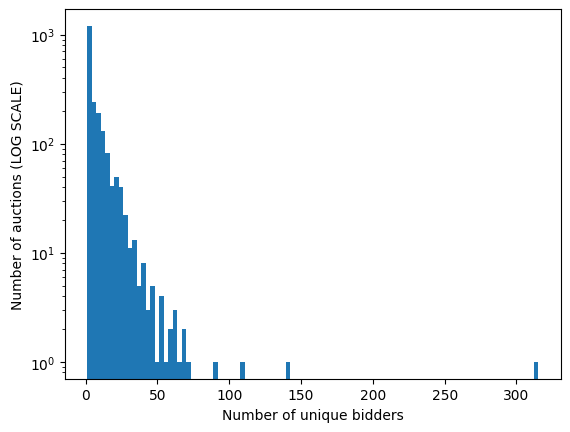

Mean number of unique bidders per auction + item combo: 4.08


Text(0, 0.5, 'Number of auctions')

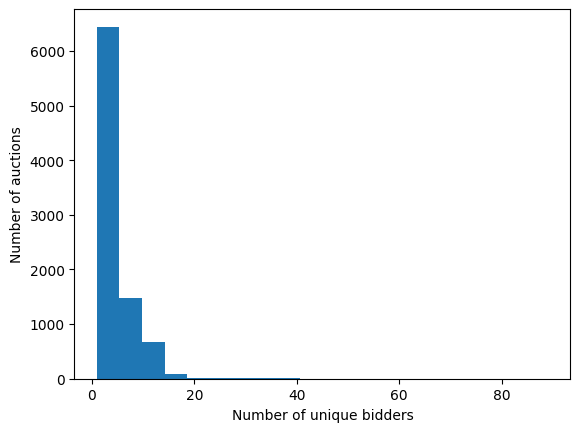

In [59]:
# what is the distribution of the number of unique bidders per auction?

print(f"Mean number of unique bidders per auction: {df.groupby('Tender Code')['CNPJ of the candidate participant'].nunique().mean():.2f}")
# y axis in log scale

plt.hist(df.groupby("Tender Code")["CNPJ of the candidate participant"].nunique(), bins=100)
plt.xlabel("Number of unique bidders")
plt.ylabel("Number of auctions (LOG SCALE)")
plt.yscale("log")
plt.show() 

# what is the distribution of the number of unique bidders per auction + item combo?

print(f"Mean number of unique bidders per auction + item combo: "
      f"{df.groupby(['Tender Code', 'Description of the contracted object'])['CNPJ of the candidate participant'].nunique().mean():.2f}")
plt.hist(df.groupby(["Tender Code", "Description of the contracted object"])["CNPJ of the candidate participant"].nunique(), bins=20)
plt.xlabel("Number of unique bidders")
plt.ylabel("Number of auctions")

Mean number of unique items per auction: 4.24


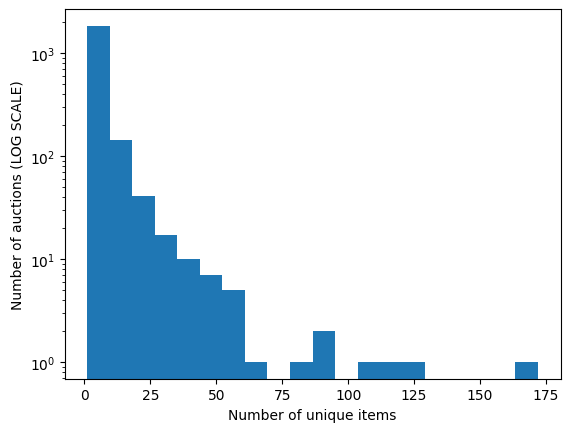

In [62]:
# what is the distribution of the number of unique items per auction?
print(f"Mean number of unique items per auction: {df.groupby('Tender Code')['Description of the contracted object'].nunique().mean():.2f}")
plt.hist(df.groupby("Tender Code")["Description of the contracted object"].nunique(), bins=20)
plt.xlabel("Number of unique items")
plt.ylabel("Number of auctions (LOG SCALE)")
plt.yscale("log")

/tmp/ipykernel_46122/1486607285.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_items"] = df.groupby("Tender Code")["Description of the contracted object"].transform("nunique")
/tmp/ipykernel_46122/1486607285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_bidders"] = df.groupby("Tender Code")["CNPJ of the candidate participant"].transform("nunique")


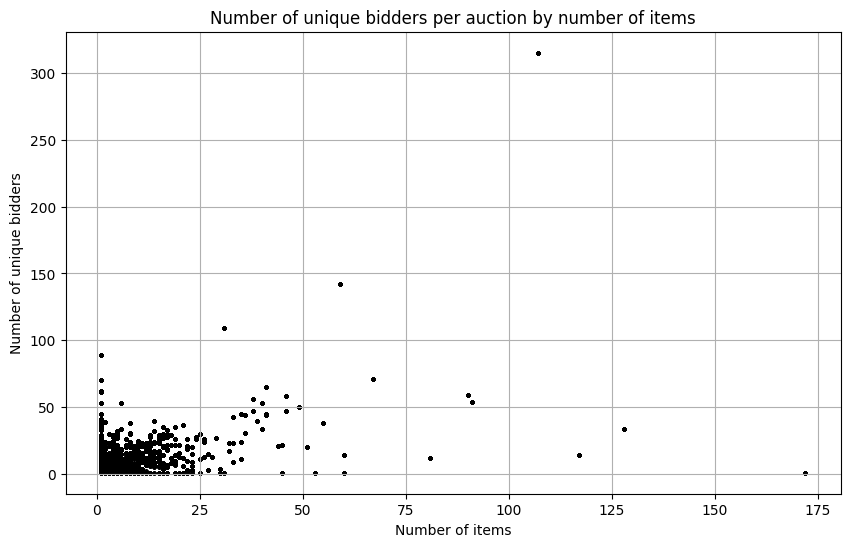

In [54]:
# does the number of bidders increase with the number of items?

import seaborn as sns

df["num_items"] = df.groupby("Tender Code")["Description of the contracted object"].transform("nunique")
df["num_bidders"] = df.groupby("Tender Code")["CNPJ of the candidate participant"].transform("nunique")

plt.figure(figsize=(10, 6))
plt.title("Number of unique bidders per auction by number of items")
plt.xlabel("Number of items")
plt.ylabel("Number of unique bidders")
plt.grid()
plt.scatter(df["num_items"], df["num_bidders"], s=3, c="black", alpha=0.8)

In [55]:
# how do we figure out who wins the auction?
# what are the unique values of "Qualification Result"?
# per google translate this is:

#'Classified - Winner', 'Disqualified', 'Disqualified',
#       'Classified', 'Didn't Show Up', 'Withdrew'

df["Qualification Result"].unique()

array(['Classificado', 'Classificado - Vencedor', 'Desclassificado', nan,
       'Inabilitado', 'Desistiu', 'Nao Compareceu'], dtype=object)

In [98]:
# Is there just one winner for each auction + item combo? No! There can be multiple winners, but rarely.

df[df["Qualification Result"] == "Classificado - Vencedor"]\
.groupby(["Tender Code", "Description of the contracted object"])["CNPJ of the candidate participant"].nunique().value_counts()

CNPJ of the candidate participant
1     5462
2       39
3        9
13       1
6        1
5        1
Name: count, dtype: int64

In [105]:
# this is explained if we condition on other factors like the item quantity. Does this mean that an auction can have
# the same item listed, each with different quantities, and each with a different winner?

df[df["Qualification Result"] == "Classificado - Vencedor"]\
.groupby(["Tender Code", "Description of the contracted object", "Item estimate budget unit value", "Budget estimate item quantity", "Proposal Value"])\
["CNPJ of the candidate participant"].nunique().value_counts()

CNPJ of the candidate participant
1    1298
Name: count, dtype: int64

(array([119.,   4.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 2.4550e+02, 4.9000e+02, 7.3450e+02, 9.7900e+02,
        1.2235e+03, 1.4680e+03, 1.7125e+03, 1.9570e+03, 2.2015e+03,
        2.4460e+03]),
 <BarContainer object of 10 artists>)

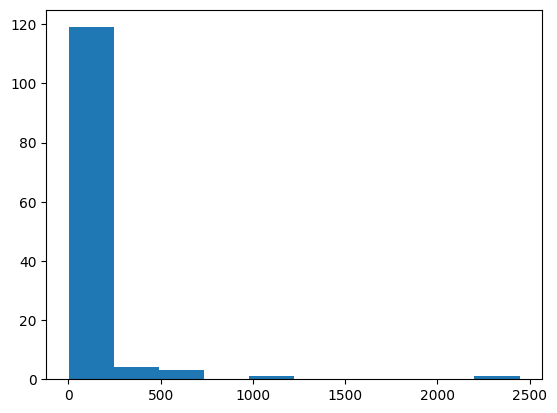

In [79]:
# How often do bidders re-bid?

plt.hist(df.groupby(["Tender Code", "Description of the contracted object"])["CNPJ of the candidate participant"].count().value_counts())

In [99]:
# as a table

df.groupby(["Tender Code", "Description of the contracted object", "CNPJ of the candidate participant"]).size().value_counts().sort_index()

1      20639
2       1467
3       8764
4       2241
5       1081
6        277
7        234
8         91
9        166
10        18
11        42
12       176
13       121
15         6
16        81
18        30
19        13
20         2
21        26
22        12
23         4
24         2
25         8
26        10
27        15
28         2
30         7
32         1
33        13
36        22
37         6
38         2
39         4
40        18
41         4
44         3
45         1
48         5
60         1
75         6
80         1
81         1
128        1
132        1
164        1
620        3
830       14
835       15
840        7
845       14
850       14
985        8
Name: count, dtype: int64

In [103]:
# find the instance where a bidder re-bid 32 times. 
# It appears that here the item estimated budget unit value and quantity is changing?? 
# Is this multiple items in the same auction?

necessary_columns = ["Tender Code", "CNPJ of the candidate participant", "Item estimate budget unit value", "Budget estimate item quantity", "Proposal Value"]
df[df.groupby(["Tender Code", "Description of the contracted object", "CNPJ of the candidate participant"]).transform("size") == 32][necessary_columns]

,Tender Code,CNPJ of the candidate participant,Item estimate budget unit value,Budget estimate item quantity,Proposal Value
1396236,2020168000080,09.260.071/,"15,46","80,0","22423,5"
1396237,2020168000080,09.260.071/,"18,9","80,0","22423,5"
1396238,2020168000080,09.260.071/,"21,67","80,0","22423,5"
1396239,2020168000080,09.260.071/,"26,9","80,0","22423,5"
1396240,2020168000080,09.260.071/,"14,89","83,0","22423,5"
1396241,2020168000080,09.260.071/,"21,67","83,0","22423,5"
1396242,2020168000080,09.260.071/,"25,38","83,0","22423,5"
1396243,2020168000080,09.260.071/,"26,9","83,0","22423,5"
1396244,2020168000080,09.260.071/,"17,16","40,0","22423,5"
1396245,2020168000080,09.260.071/,"18,34","40,0","22423,5"


In [112]:
# Conditioning on uniqueness of the estimated budget unit value and quantity, list number of repeat bids
repeat_bids = df.groupby(
    ["Tender Code", "Description of the contracted object", "CNPJ of the candidate participant", "Item estimate budget unit value", "Budget estimate item quantity",]
).size().value_counts().sort_index()
print(repeat_bids)
print(repeat_bids / repeat_bids.sum())

1     6966
2      580
3      694
4      658
5       42
6        7
8       15
9       43
10      30
12       7
16       3
20       4
Name: count, dtype: int64
1     0.769809
2     0.064095
3     0.076694
4     0.072715
5     0.004641
6     0.000774
8     0.001658
9     0.004752
10    0.003315
12    0.000774
16    0.000332
20    0.000442
Name: count, dtype: float64


In [109]:
# How often does an auction have a winner?

auction_results = df.groupby(["Tender Code", "Description of the contracted object"])["Qualification Result"].apply(lambda x: "Classificado - Vencedor" in x.values).value_counts()
auction_results / auction_results.sum()

Qualification Result
True     0.629769
False    0.370231
Name: count, dtype: float64

In [107]:
# What is the distribution of outcomes for bidders?

df["Qualification Result"].value_counts() / len(df)

Qualification Result
Classificado               0.742415
Classificado - Vencedor    0.141723
Desclassificado            0.073691
Inabilitado                0.002932
Desistiu                   0.002918
Nao Compareceu             0.002521
Name: count, dtype: float64